based on

- http://www.cs.bme.hu/~oti/portfolio/icpproject/20110227/ch4.pdf
- https://math.bme.hu/alkmat/alkmat2013/eloadasok/gyorfi.pdf
- http://www.szit.bme.hu/~oti/portfolio/articles/tgyorfi.pdf
- http://www.cs.bme.hu/~oti/portfolio/articles/NN.pdf

not deployed

In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.covariance import ledoit_wolf
import cvxpy

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position,
    get_feature_columns,
    get_symbols,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, interval_sec=24 * 60 * 60, horizon=1)
df.to_pickle('/tmp/df_daily_horizon1.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     31.555300     28.937300   
                          BTC     10532.400561  11094.361621  10385.558949   
                          ETH       221.191514    235.735515    220.461791   
                          XRP         0.319763      0.341772      0.319140   
2019-07-21 00:00:00+00:00 BNB        31.135900     31.551650     29.352900   
...                                        ...           ...           ...   
2022-09-05 00:00:00+00:00 ETH      1579.064286   1628.670000   1558.007143   
                          LINK        7.155066      7.411403      7.098418   
                          MATIC       0.895041      0.902724      0.862265   
                          SOL        32.168248     32.487722     31.160643   
                          XRP         0.331550      0.333462      0.322754   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        31.135900 2019-07-21 00:00:00+00:00   
                          BTC     10758.259167 2019-07-21 00:00:00+00:00   
                          ETH       229.000753 2019-07-21 00:00:00+00:00   
                          XRP         0.333653 2019-07-21 00:00:00+00:00   
2019-07-21 00:00:00+00:00 BNB        30.417250 2019-07-22 00:00:00+00:00   
...                                        ...                       ...   
2022-09-05 00:00:00+00:00 ETH      1616.531429 2022-09-06 00:00:00+00:00   
                          LINK        7.369307 2022-09-06 00:00:00+00:00   
                          MATIC       0.881813 2022-09-06 00:00:00+00:00   
                          SOL        32.162763 2022-09-06 00:00:00+00:00   
                          XRP         0.332983 2022-09-06 00:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.005105  
                          BTC     0.002140  
                          ETH    -0.000328  
                          XRP     0.002683  
2019-07-21 00:00:00+00:00 BNB    -0.000617  
...                                    ...  
2022-09-05 00:00:00+00:00 ETH     0.012884  
                          LINK   -0.001292  
                          MATIC   0.024761  
                          SOL     0.007695  
                          XRP    -0.000309  

[10278 rows x 6 columns]

In [33]:
import faiss

class ExampleModelPortfolio:
    def __init__(self):
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script 
    
    def fit(self, df):
        self.symbols = get_symbols(df) # for predict script 
    
    def predict(self, df):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values='cl'
        )
        df_x = (df_x / df_x.shift(1) - 1).fillna(0)
        
        k = 30
        l = 100
        idx_to_pos = {}
        index = faiss.IndexFlatL2(k * df_x.shape[1])
        
        df_weight = df_x.copy() * 0
        idx = 0
        for i in range(k, df_x.shape[0]):
            v_old = df_x.iloc[i - k + 1 - 1:i + 1 - 1].values.flatten().astype('float32')
            index.add(v_old.reshape(1, -1))
            idx_to_pos[idx] = i - 1
            idx += 1
            
            if idx < l:
                continue
            
            v = df_x.iloc[i - k + 1:i + 1].values.flatten().astype('float32')
            D, I = index.search(v.reshape(1, -1), l)
            ret_nns = []
            for j in I[0]:
                pos = idx_to_pos[j]
                ret_nn = df_x.iloc[pos + 1].values.flatten()
                ret_nns.append(ret_nn)
            ret_nns = np.array(ret_nns)
            
            S, _ = ledoit_wolf(ret_nns)
            mu = np.mean(ret_nns, axis=0)

            weight = optimize_mv(
                mu=mu, 
                S=S, 
                target_std=0.04 / (24 ** 0.5), 
                max_total_pos=1.0
            )
            df_weight.iloc[i, :] = weight
        
        df2 = df_weight.stack()
        df['position'] = df2.loc[df.index].fillna(0)
        
#         normalize_position(df)
        return df['position']

    
def optimize_mv(mu=None, S=None, target_std=None, max_total_pos=None):
    x = cvxpy.Variable(mu.shape[0])
    S = np.array(S)
    mu = np.array(mu)

    objective = cvxpy.Minimize(-mu @ x)
    constraints = [
        cvxpy.quad_form(x, S) <= target_std ** 2,
    ]
    
    if max_total_pos is not None:
        constraints += [
            cvxpy.sum(cvxpy.abs(x)) <= max_total_pos,
        ]

    prob = cvxpy.Problem(objective, constraints)

    try:
        result = prob.solve()
        weight = x.value
        if weight is None:
            print('weight is None')
            weight = np.zeros(mu.size)
    except Exception as e:
        print(e)
        weight = np.zeros(mu.size)

    return weight

return without cost statistics
mean -9.71903684083336e-06
std 0.0036225240701946186
sharpe -0.002682946104016145
max drawdown 0.09012894399530466
return with cost statistics
mean -0.000607311708740778
std 0.0036194030945187463
sharpe -0.16779333301131777
max drawdown 0.09015711334723536


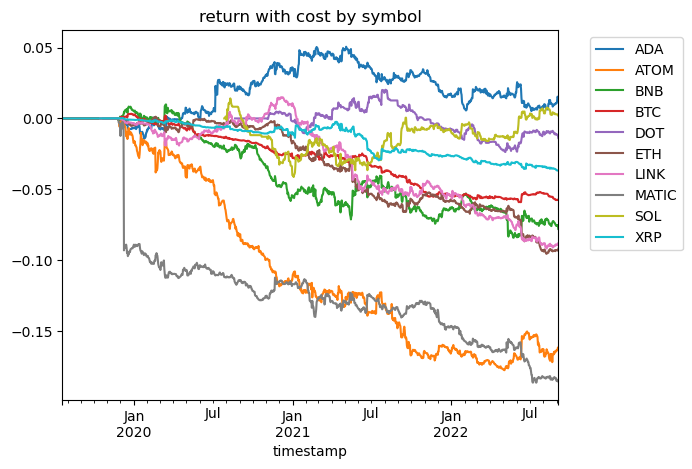

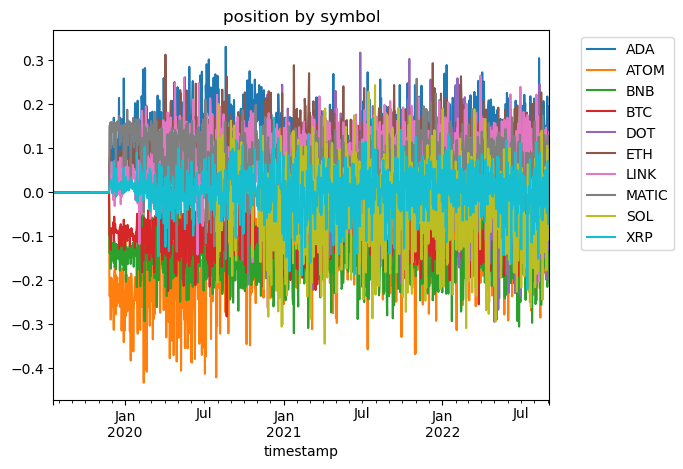

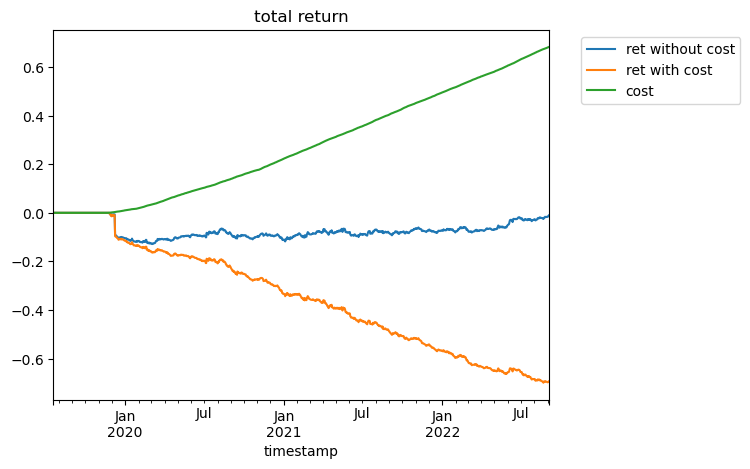

In [34]:
df = pd.read_pickle('/tmp/df_daily_horizon1.pkl')

model = ExampleModelPortfolio()

df['pos'] = model.predict(df)
visualize_result(df.dropna())

# save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model_portfolio.xz', 'wb') as f:
    f.write(data)

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model_portfolio.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)

timestamp                  symbol
2022-06-30 12:00:00+00:00  ADA       0.0
                           ATOM      0.0
                           BNB       0.0
                           BTC       0.0
                           DOT       0.0
                                    ... 
2022-08-29 12:00:00+00:00  ETH       0.0
                           LINK      0.0
                           MATIC     0.0
                           SOL       0.0
                           XRP       0.0
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
